In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
import tensorflow as tf

from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageLRFlpTransformation

In [3]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [4]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
TRAIN_DIR = DATA_DIR/'train'
images = [str(TRAIN_DIR/label_dir/val) for label_dir in os.listdir(TRAIN_DIR) for val in os.listdir(TRAIN_DIR/label_dir)]

In [6]:
train_df = pd.DataFrame()
train_df['path'] = images
train_df['label'] = train_df['path'].apply(lambda path : path.split("/")[2])

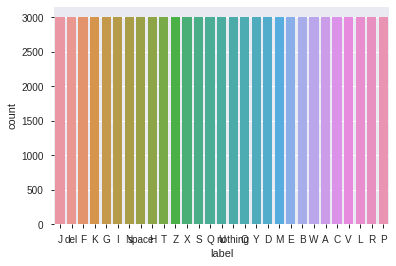

In [7]:
sns.countplot(x='label', data=train_df);

In [8]:
TEST_DIR = DATA_DIR/'test'
test_images = [str(TEST_DIR/val) for val in os.listdir(TEST_DIR)]

In [9]:
test_df = pd.DataFrame()
test_df['path'] = test_images
test_df['label'] = test_df['path'].apply(lambda path : path.split("/")[-1].split("_")[0])

In [10]:
test_df.head()

,path,label
0,data/test/L_test.jpg,L
1,data/test/A_test.jpg,A
2,data/test/G_test.jpg,G
3,data/test/Q_test.jpg,Q
4,data/test/I_test.jpg,I


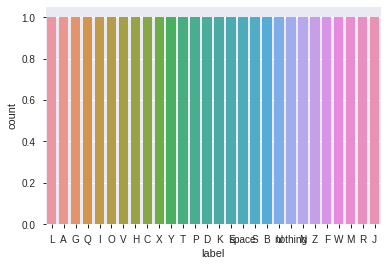

In [11]:
sns.countplot(x='label', data=test_df);

In [12]:
IMG_DIMS = (150, 150, 3)

In [13]:
train_data, validation_data = train_test_split(train_df, test_size=0.2)

In [14]:
test_data = test_df.copy()

In [15]:
[data.shape for data in [train_data, validation_data]]

[(69600, 2), (17400, 2)]

In [16]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=16,
    preprocess_pipeline=[
        ImageParser()
    ],
)

train_dataset = ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageLRFlpTransformation()
        ],
        shuffle=True,
    )).build_from_df(train_data, 'path', 'label')

data_container = DataContainer(
    train=train_dataset,
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageLRFlpTransformation(),
        ],
    ))
        .with_label_map(train_dataset.label_map)
        .build_from_df(validation_data, 'path', 'label'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'path', 'label'),
)

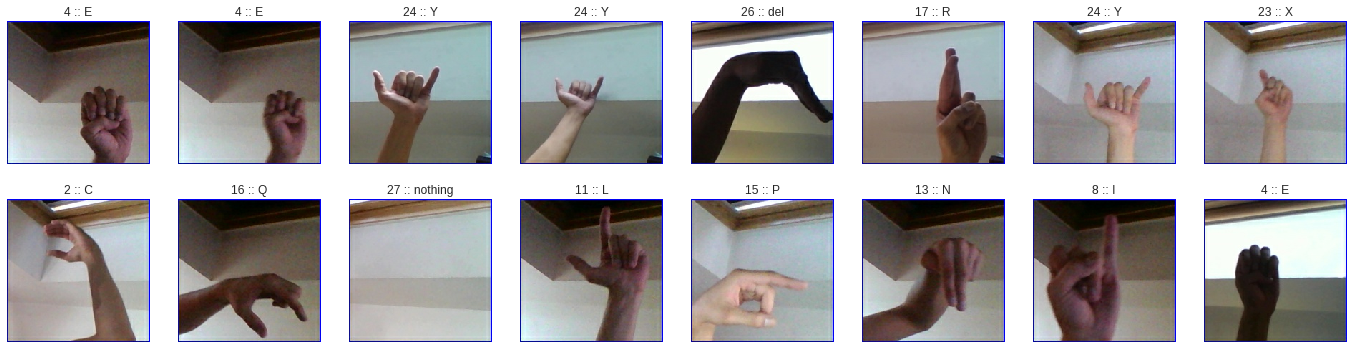

In [17]:
data_container.train.show()

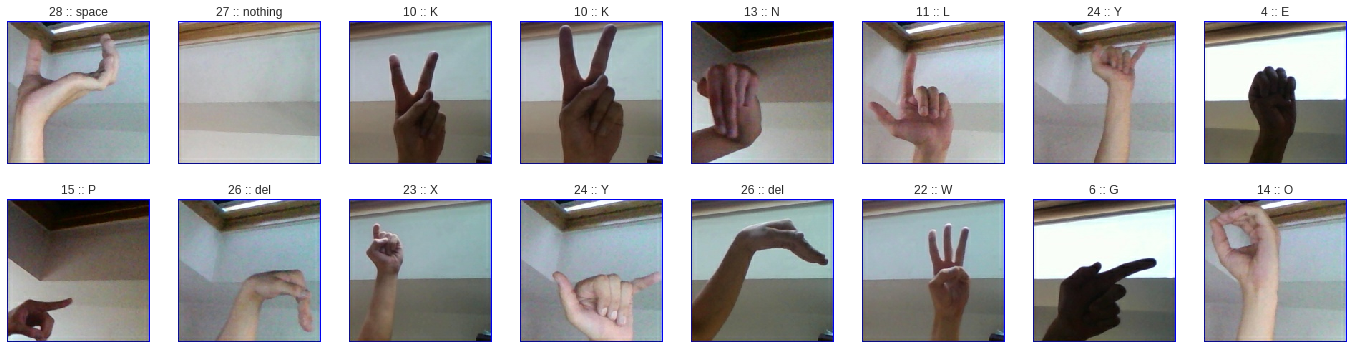

In [18]:
data_container.validation.show()

In [23]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.2,
)

In [24]:
learner.auto_train(
    easing_epochs=2,
    epochs=3,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

Freezing all except last model layers
Training frozen model
Train for 4350 steps, validate for 1088 steps
Epoch 1/2
4350/4350 [==============================] - 241s 55ms/step - loss: 2.2578 - sparse_categorical_accuracy: 0.0580 - val_loss: 3.4680 - val_sparse_categorical_accuracy: 0.0520
Epoch 2/2
4350/4350 [==============================] - 231s 53ms/step - loss: 1.6867 - sparse_categorical_accuracy: 0.1410 - val_loss: 4.1405 - val_sparse_categorical_accuracy: 0.0737
Loading weights only from xception/weights.h5
Model loaded successfully
Unfreezing all layers
Finished training frozen model
Starting model training
Train for 4350 steps, validate for 1088 steps
Epoch 1/3
4350/4350 [==============================] - 786s 181ms/step - loss: 0.7917 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9212
Epoch 2/3
4350/4350 [==============================] - 781s 179ms/step - loss: 0.3105 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.2993 - v

In [25]:
learner.analyze_dataset(verbose=1)

    1/17400 [..............................] - ETA: 5:28

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (None, 1)